# LSTM--week

In [11]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [12]:
import os
os.sys.executable


'd:\\Program\\Anaconda3\\envs\\Predict\\python.exe'

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [14]:
ori_data=pd.read_csv("order_train1.csv",encoding='utf-8')
ori_data.head()
# out=pd.read_csv("predict_sku_week.csv",encoding='utf-8')
out=pd.read_csv("周时间粒度的预测结果.csv",encoding='utf-8')
out.head()

,sales_region_code,item_code,month1,month2,month3
0,101,20002,844.061408,3667.282699,10398.71920
1,101,20003,0.000000,0.000000,0.00000
2,101,20006,5240.374831,11681.012970,22798.12709
3,101,20011,0.000000,0.000000,0.00000
4,101,20014,162196.465900,216319.706800,182099.37890


In [15]:

simulation_size = 5 # 重复次数

In [16]:
# 参数设置
num_layers = 1          # LSTM单元个数
size_layer = 128        # 一层神经网络中的中神经元个数
timestamp = 5           # 时间步（从过去X天预测未来1天）
epoch = 150            # 迭代次数
dropout_rate = 0.8      # 跳出参数--防止过拟合
learning_rate = 0.01    # 学习率

In [17]:
# LSTM模型
class Model:
    def __init__(
        self,
        learning_rate,  # 学习率
        num_layers,     # LSTM单元个数
        size,           # 输入神经元个数
        size_layer,     # LSTM单层神经网络中的神经元个数
        output_size,    # 输出神经元个数（预测值）
        forget_bias = 0.1, # 忘记门指数
    ):
        # ———————————————————定义神经网络————————————————————————————
        def lstm_cell(size_layer):  # 单层神经网络
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(    # 整个神经网络
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        
        self.X = tf.placeholder(tf.float32, (None, None, size)) # 输入X：三维
        self.Y = tf.placeholder(tf.float32, (None, output_size)) # 输出Y：二维
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper( # 跳出
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(         # 隐藏层
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(  # 输出&末状态
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

# 准确度计算    
def calculate_accuracy(real, predict):
    real = np.array(real) + 1   # 除0
    predict = np.array(predict) + 1
    percentage = 1-np.sqrt(np.mean(np.square(abs(real - predict) / real)))
    return percentage * 100


def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

def print_loss(theloss):
    print(theloss)
    plt.figure()
    plt.plot(list(range(len(theloss))), theloss)
    plt.xlabel('times', fontsize=14)
    plt.ylabel('loss value', fontsize=14)
    plt.title('Loss', fontsize=10)
    plt.show()

In [18]:
# LSTM预测
def forecast():
    tf.reset_default_graph()
    # 如果没有这行代码 就没有办法多次调用该模型
    # 清除默认图形并重置全局默认图形
    modelnn = Model(
        learning_rate, num_layers, df_train.shape[1], size_layer, df_train.shape[1], dropout_rate
    )
    # 初始化
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist() # 获取日期

    # 训练得到LSTM模型
    pbar = tqdm(range(epoch), desc = 'train loop') # 迭代次数
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer)) # LSTM层数*个数*2
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp): 
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(               # 构建训练数据X
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(         #运行模型
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )        
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    # 预测未来数据
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    # 反归一化
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)
    
    return deep_future

In [19]:
def final_process(regioncode,itemcode,test_size,results):
    
    # 日期转换
    date_ori = pd.to_datetime(data.iloc[:, 0]).tolist()
    for i in range(test_size):
        date_ori.append(date_ori[-1] + timedelta(days = 7))
    date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

    # 判断能用的线条
    accepted_results = []
    for r in results:
        if (np.array(r[-test_size:]) < np.min(data['ord_qty'])).sum() == 0 and \
        (np.array(r[-test_size:]) > np.max(data['ord_qty']) * 2).sum() == 0:
            accepted_results.append(r)
    if len(accepted_results)==0:
        return [0,0,0,0]

    # 绘图
    accuracies = [calculate_accuracy(data['ord_qty'].values, r[:-test_size]) for r in results]

    plt.figure(figsize = (15, 5))
    for no, r in enumerate(accepted_results):
        plt.plot(r, label = 'forecast %d'%(no + 1))
    plt.plot(data['ord_qty'], label = 'true trend', c = 'black')
    plt.title('regioncode: %s item_code: %s'%(str(regioncode),str(itemcode)))

    x_range_future = np.arange(len(accepted_results[0]))
    plt.xticks(x_range_future[::10], date_ori[::10],rotation=30)
    plt.legend()
    figname='C:/Users/Huilin Yao/Desktop/泰迪杯2023/周结果/'+'regioncode为'+str(regioncode)+'item_code为'+str(itemcode)+'的周预测量'+'.png'
    plt.savefig(figname,bbox_inches='tight')

    # 存储预测结果
    index=np.argmax(accuracies)
    final_data=results[index]
    final_data=final_data[-test_size:]
    x1=pd.DataFrame(final_data)
    x2=pd.date_range(start="2018/12/23",end="2019/03/31",freq="7D")
    x2=pd.DataFrame(x2)
    final_result=pd.concat([x2,x1],axis=1)
    final_result.columns=['日期','预测需求量']
    name='C:/Users/Huilin Yao/Desktop/泰迪杯2023/周结果/'+'regioncode为'+str(regioncode)+'item_code为'+str(itemcode)+'的周预测量'+'.csv'
    final_result.to_csv(name,index=False)

    # 存储最终结果
    m1=np.sum(final_data[:5])
    m2=np.sum(final_data[5:9])
    m3=np.sum(final_data[9:])
    outcome=[regioncode,itemcode,m1,m2,m3]
    print(outcome)
    return outcome


%s pass 20002.0
20003.0
%s redo 20003.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:06<00:00, 23.48it/s, acc=96.6, cost=0.00338]


%s pass 20006.0
20011.0
%s pass 20014.0
%s pass 20016.0
%s pass 20018.0
%s pass 20020.0
%s pass 20021.0
%s pass 20024.0
%s pass 20039.0
%s pass 20041.0
%s pass 20046.0
%s pass 20049.0
%s pass 20055.0
%s pass 20058.0
20076.0
%s redo 20076.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:08<00:00, 17.91it/s, acc=97.8, cost=0.00123] 


%s pass 20085.0
20086.0
%s redo 20086.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:09<00:00, 15.26it/s, acc=96.9, cost=0.00279]


20088.0
20089.0
%s redo 20089.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:05<00:00, 27.68it/s, acc=95.4, cost=0.00551]


%s pass 20091.0
%s pass 20093.0
%s pass 20107.0
%s pass 20111.0
20113.0
%s redo 20113.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:01<00:00, 82.88it/s, acc=92.3, cost=0.0135] 


[101.0, 20113.0, 25654.089007979495, 165687.71602078417, 473796.91591515]
20114.0
%s pass 20118.0
%s pass 20119.0
%s pass 20121.0
%s pass 20127.0
20131.0
%s redo 20131.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:02<00:00, 53.79it/s, acc=96.6, cost=0.00245]


20134.0
%s redo 20134.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:08<00:00, 18.74it/s, acc=96.7, cost=0.00319]


20135.0
%s redo 20135.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:08<00:00, 18.44it/s, acc=95, cost=0.00645]  


20139.0
%s redo 20139.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop: 100%|██████████| 150/150 [00:08<00:00, 16.89it/s, acc=96.3, cost=0.00369]


%s pass 20140.0
%s pass 20142.0
%s pass 20145.0
%s pass 20146.0
%s pass 20150.0
20151.0
%s redo 20151.0
simulation 1
simulation 2
simulation 3
simulation 4
simulation 5


train loop:  61%|██████    | 91/150 [00:05<00:03, 18.14it/s, acc=96.4, cost=0.0033] 


KeyboardInterrupt: 

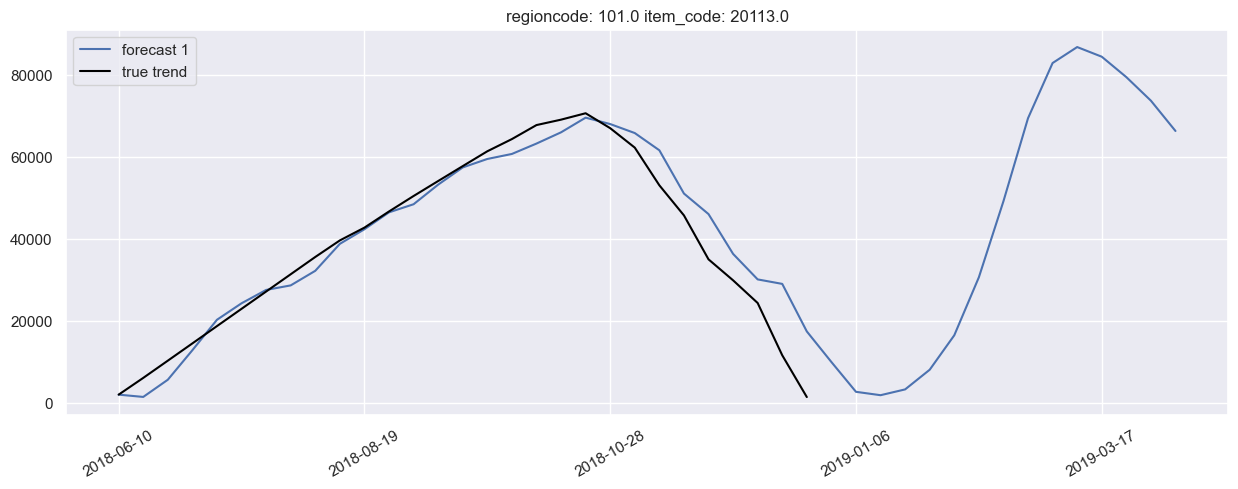

In [20]:
# 总流程
outcomes=[]
for index,row in out.iterrows():
    rcode=row['sales_region_code']
    icode=row['item_code']

    # 说明已经处理好了
    if row['month1'] >0:
        print('%s pass',icode)
        continue
    
    print(icode)
    # 数据提取
    data=ori_data[(ori_data['item_code']==icode)&(ori_data['sales_region_code']==rcode)]

    if data.empty:
        outcome=[rcode,icode,0,0,0]
        outcomes.append(outcome)
        continue
    
    print('%s redo',icode)
    # 数据预处理
    # 将同一天的数据进行合并
    # 缺失数据进行补充
    exday=pd.to_datetime(data.iloc[0,0])+pd.Timedelta(days=-1)

    exqty=0
    exprice=0
    alist=[]
    for index,row in data.iterrows():
        day=(pd.to_datetime(row['order_date'])-exday).days
        if day>1:
            # 缺失日补充
            qty=(row['ord_qty']-exqty)/day
            price=(row['item_price']-exprice)/day
            for i in range(day-1):
                date=exday+pd.Timedelta(days=(i+1))
                value=[date,0,0,0,0,0,exprice+price*(i+1),exqty+qty*(i+1),0,0]
                alist.append(value)
        else:
            if day==0:
                # 同一天数据进行合并
                row['item_price']=(row['item_price']+exprice)/2
                row['ord_qty']=(row['ord_qty']+exqty)/2
    exday=pd.to_datetime(row['order_date'])
    exqty=row['ord_qty']
    exprice=row['item_price']

    # 删除同一日数据
    data=data.drop_duplicates(subset=['order_date'],keep='last')
    # 日期排序
    data1=pd.DataFrame(alist,columns=data.columns)
    data=pd.concat([data,data1],axis=0)
    data['order_date']=pd.to_datetime(data['order_date'])
    data=data.sort_values(by='order_date',ascending=True)
    data.reset_index(drop=True, inplace=True) # 重新排序

    # 按照周进行运算(7天1合并)
    # 产生新的data：week ord_qty
    data.index=data['order_date']
    data=data['ord_qty']
    data_month=data.resample('w').sum()
    data_month=data_month.rename_axis('order_data').reset_index()
    data=data_month

    # Y特征处理&提取
    minmax = MinMaxScaler().fit(data.iloc[:, 1:2]) # ord_qty
    df_log = minmax.transform(data.iloc[:, 1:2]) # ord_qty
    df_log = pd.DataFrame(df_log)
    df_log.head()
    df_train=df_log

    # 变量设置--week
    test_size=((pd.to_datetime("2019/03/31")-pd.to_datetime(data.iloc[-1,0])).days)//7+1
    future_day = test_size

    # 模拟运算
    results = []
    for i in range(simulation_size):
        print('simulation %d'%(i + 1))
    results.append(forecast())

    # 画图&结果存储

    outcome=final_process(rcode,icode,test_size,results) 
    outcomes.append(outcome)


outcomes=pd.DataFrame(outcomes,columns=['sales_region_code','item_code','2019.01预测需求量','2019.02预测需求量','2019.01预测需求量']) 
name='C:/Users/Huilin Yao/Desktop/泰迪杯2023/'+'周时间粒度的预测结果haha'+'.csv'
outcomes.to_csv(name,index=False)
